# Import all packages and library

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_absolute_error
from mordred import Calculator, descriptors
from sklearn.ensemble import RandomForestRegressor
from rdkit import Chem
import pickle #to save the desc file 
import pandas as pd
import numpy as np

In [2]:
data = pd.read_json('../datasets/qm9.json.gz', lines=True)  # Do not need the full set to make a point.
print(f'Loaded {len(data)} molecules')


Loaded 25000 molecules


In [3]:
data['mol'] = data['smiles_0'].apply(Chem.MolFromSmiles)

In [4]:
calc = Calculator(descriptors, ignore_3D=True)

In [5]:
print(f'First 10 out of {len(calc.descriptors)} descriptors')
calc.descriptors[:10]


First 10 out of 1613 descriptors


(mordred.ABCIndex.ABCIndex(),
 mordred.ABCIndex.ABCGGIndex(),
 mordred.AcidBase.AcidicGroupCount(),
 mordred.AcidBase.BasicGroupCount(),
 mordred.AdjacencyMatrix.AdjacencyMatrix('SpAbs'),
 mordred.AdjacencyMatrix.AdjacencyMatrix('SpMax'),
 mordred.AdjacencyMatrix.AdjacencyMatrix('SpDiam'),
 mordred.AdjacencyMatrix.AdjacencyMatrix('SpAD'),
 mordred.AdjacencyMatrix.AdjacencyMatrix('SpMAD'),
 mordred.AdjacencyMatrix.AdjacencyMatrix('LogEE'))

In [6]:
#desc = calc.pandas(data['mol'])


In [7]:
#f = open("desc.dat", "wb")

In [8]:
#pickle.dump(desc,f)

In [9]:
#f.close()

In [10]:
f = open("desc.dat", "rb")

In [11]:
desc=pickle.load(f)

In [12]:
f.close()

In [13]:
print(f'Computed {len(desc.columns)} descriptors for {len(desc)} molecules')

Computed 1613 descriptors for 25000 molecules


# Drop missing values

In [14]:
zero_variation = [c for c, s in desc.std().items() if s == 0]

/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [15]:
print(f'{len(zero_variation)} ({len(zero_variation) / len(desc.columns) *100:.1f}%) features are constant for the dataset. Examples: {zero_variation[:5]}')

188 (11.7%) features are constant for the dataset. Examples: ['nB', 'nS', 'nP', 'nCl', 'nBr']


In [16]:
desc.drop(columns=zero_variation, inplace=True)
print(f'New shape: {desc.shape}')

New shape: (25000, 1425)


In [17]:
for c in desc.columns:
    desc[c] = pd.to_numeric(desc[c], errors='coerce')

In [18]:
missing_values = desc.isnull().any()
print(f'Found {missing_values.sum()} columns with missing values')

Found 546 columns with missing values


In [19]:
desc = desc.loc[:, ~missing_values]  # Gets only columns that do not (~ means not) have missing values
print(f'New shape: {desc.shape}')

New shape: (25000, 879)


# LASSOCV and RandomForest training


In [20]:
model_wPCA = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=8)),
    ('lasso', LassoCV())
])

In [21]:
model_woPCA = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', LassoCV())
])

In [22]:
model_RFR = Pipeline([
    ('scale', StandardScaler()),
    ('randomforest', RandomForestRegressor())
])

# Training_size=10000


In [23]:
train_data, test_data, train_desc, test_desc = train_test_split(data, desc, train_size=10000, test_size=2000)

In [24]:
test_data = test_data.copy()  
test_data['LASSOCV-wPCA-model'] = model_wPCA.fit(train_desc, train_data['bandgap']).predict(test_desc)

In [25]:
test_data = test_data.copy()  
test_data['LASSOCV-woPCA-model'] = model_woPCA.fit(train_desc, train_data['bandgap']).predict(test_desc)

/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020451452875112075, tolerance: 0.001750531801878875
  tol, rng, random, positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018815574074322328, tolerance: 0.00175234656395
  tol, rng, random, positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003955704959108353, tolerance: 0.00175234656395
  tol, rng, random, positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/p

In [26]:
test_data = test_data.copy()  
test_data['RFR-model'] = model_RFR.fit(train_desc, train_data['bandgap']).predict(test_desc)

In [27]:
MSE_LASSOCV_wPCA_model_10000 = mean_absolute_error(test_data['bandgap'],test_data['LASSOCV-wPCA-model'])
MSE_LASSOCV_wPCA_model_10000

0.02632304809792565

In [28]:
MSE_LASSOCV_woPCA_model_10000 = mean_absolute_error(test_data['bandgap'],test_data['LASSOCV-woPCA-model'])
MSE_LASSOCV_woPCA_model_10000

0.01150158833677827

In [29]:
MSE_RFR_model_10000 = mean_absolute_error(test_data['bandgap'],test_data['RFR-model'])
MSE_RFR_model_10000

0.008924283999999998

# Training_size=1000


In [30]:
train_data, test_data, train_desc, test_desc = train_test_split(data, desc, train_size=1000, test_size=2000)

In [31]:
test_data = test_data.copy()  
test_data['LASSOCV-wPCA-model'] = model_wPCA.fit(train_desc, train_data['bandgap']).predict(test_desc)

In [32]:
test_data = test_data.copy()  
test_data['LASSOCV-woPCA-model'] = model_woPCA.fit(train_desc, train_data['bandgap']).predict(test_desc)

/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033334168809573406, tolerance: 0.00018028708688
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004378296588957442, tolerance: 0.00018028708688
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019469983641154376, tolerance: 0.00018028708688
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate

/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008414060453448974, tolerance: 0.00018017221479875003
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032349705497472514, tolerance: 0.00017528670515500004
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004541388076657049, tolerance: 0.00017528670515500004
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_

In [33]:
test_data = test_data.copy()  
test_data['RFR-model'] = model_RFR.fit(train_desc, train_data['bandgap']).predict(test_desc)

In [34]:
MSE_LASSOCV_wPCA_model_1000 = mean_absolute_error(test_data['bandgap'],test_data['LASSOCV-wPCA-model'])
MSE_LASSOCV_wPCA_model_1000

0.02557094814121244

In [35]:
MSE_LASSOCV_woPCA_model_1000 = mean_absolute_error(test_data['bandgap'],test_data['LASSOCV-woPCA-model'])
MSE_LASSOCV_woPCA_model_1000

0.013300532579149447

In [36]:
MSE_RFR_model_1000 = mean_absolute_error(test_data['bandgap'],test_data['RFR-model'])
MSE_RFR_model_1000

0.012246986999999997

# Training_size=100


In [37]:
train_data, test_data, train_desc, test_desc = train_test_split(data, desc, train_size=100, test_size=2000)# Training_size=10000


In [38]:
test_data = test_data.copy()  
test_data['LASSOCV-wPCA-model'] = model_wPCA.fit(train_desc, train_data['bandgap']).predict(test_desc)

In [39]:
test_data = test_data.copy()  
test_data['LASSOCV-woPCA-model'] = model_woPCA.fit(train_desc, train_data['bandgap']).predict(test_desc)

/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1031942023098764e-05, tolerance: 1.7337913950000005e-05
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8137533677338316e-05, tolerance: 1.7337913950000005e-05
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1646608653482435e-05, tolerance: 1.7337913950000005e-05
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linea

In [40]:
test_data = test_data.copy()  
test_data['RFR-model'] = model_RFR.fit(train_desc, train_data['bandgap']).predict(test_desc)

In [41]:
MSE_LASSOCV_wPCA_model_100 = mean_absolute_error(test_data['bandgap'],test_data['LASSOCV-wPCA-model'])
MSE_LASSOCV_wPCA_model_100

0.029052758355669075

In [42]:
MSE_LASSOCV_woPCA_model_100 = mean_absolute_error(test_data['bandgap'],test_data['LASSOCV-woPCA-model'])
MSE_LASSOCV_woPCA_model_100

0.0191066697101104

In [43]:
MSE_RFR_model_100 = mean_absolute_error(test_data['bandgap'],test_data['RFR-model'])
MSE_RFR_model_100

0.017696689500000005

# Training_size=10


In [44]:
train_data# Training_size=10000
, test_data, train_desc, test_desc = train_test_split(data, desc, train_size=10, test_size=2000)

('test_data,',
 'train_desc,',
 'test_desc',
 '=',
 'train_test_split(data,',
 'desc,',
 'train_size=10,',
 'test_size=2000)')

In [45]:
test_data = test_data.copy()  
test_data['LASSOCV-wPCA-model'] = model_wPCA.fit(train_desc, train_data['bandgap']).predict(test_desc)

In [46]:
test_data = test_data.copy()  
test_data['LASSOCV-woPCA-model'] = model_woPCA.fit(train_desc, train_data['bandgap']).predict(test_desc)

/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1031942023098764e-05, tolerance: 1.7337913950000005e-05
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8137533677338316e-05, tolerance: 1.7337913950000005e-05
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1646608653482435e-05, tolerance: 1.7337913950000005e-05
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linea

In [47]:
test_data = test_data.copy()  
test_data['RFR-model'] = model_RFR.fit(train_desc, train_data['bandgap']).predict(test_desc)

In [48]:
MSE_LASSOCV_wPCA_model_10 = mean_absolute_error(test_data['bandgap'],test_data['LASSOCV-wPCA-model'])
MSE_LASSOCV_wPCA_model_10

0.029053020960381985

In [49]:
MSE_LASSOCV_woPCA_model_10 = mean_absolute_error(test_data['bandgap'],test_data['LASSOCV-woPCA-model'])
MSE_LASSOCV_woPCA_model_10

0.0191066697101104

In [50]:
MSE_RFR_model_10 = mean_absolute_error(test_data['bandgap'],test_data['RFR-model'])
MSE_RFR_model_10

0.017779839000000002

Text(0, 0.5, 'MSE')

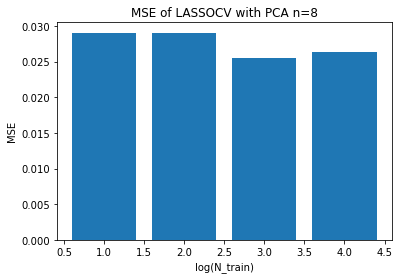

In [62]:
plt.bar([1, 2, 3, 4],[MSE_LASSOCV_wPCA_model_10,MSE_LASSOCV_wPCA_model_100,MSE_LASSOCV_wPCA_model_1000,MSE_LASSOCV_wPCA_model_10000])
plt.title('MSE of LASSOCV model with PCA n=8')
plt.xlabel('log(N_train)')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

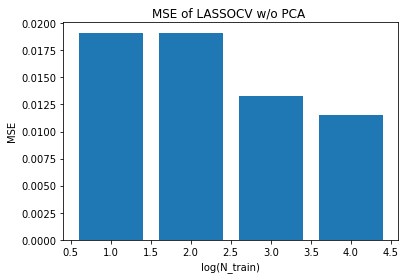

In [63]:
plt.bar([1, 2, 3, 4],[MSE_LASSOCV_woPCA_model_10,MSE_LASSOCV_woPCA_model_100,MSE_LASSOCV_woPCA_model_1000,MSE_LASSOCV_woPCA_model_10000])
plt.title('MSE of LASSOCV model w/o PCA ')
plt.xlabel('log(N_train)')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

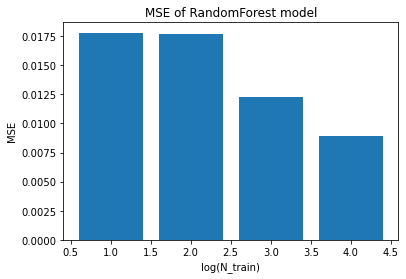

In [64]:
plt.bar([1, 2, 3, 4],[MSE_RFR_model_10,MSE_RFR_model_100,MSE_RFR_model_1000,MSE_RFR_model_10000])
plt.title('MSE of RandomForest model')
plt.xlabel('log(N_train)')
plt.ylabel('MSE')

# Chemical Descriptors Q1:


Figures have been shown as above. Observe the MSE between three models, we can see that LASSOCV model with PCA(n=8) gives the larger error no matter how large the traning set size is. The LASSOCV model without PCA ranks second and the Random Forset model gives the best prediction. 


Q1:How do the results compare? Why do some models continue to improve at large training set sizes while others do not?


Observe the changes of MSE as the training set sizes increase, we found that LASSOCV model with PCA(n=8) doesn't improve as the training set sizes change from 1000 to 10000. This is because we only allowed 8 main features to fit the data points, but only 8 main features is not enough to describe the whole 10000 data points. Thus even with the larger training set size, the model didn't give the better results. RF and LASSOCV without PCA contain all features so their performance become better with larger training set size. 

# Chemical Descriptors Q2:

In [51]:
train_data, test_data, train_desc, test_desc = train_test_split(data, desc, train_size=10000, test_size=2000)

In [73]:
scaler = StandardScaler()
feats = scaler.fit_transform(train_desc)

In [75]:
lasso_woPCA = LassoCV().fit(feats, train_data['bandgap'])


/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002641366367725162, tolerance: 0.0017768059704988753
  tol, rng, random, positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023426394462977562, tolerance: 0.0017768059704988753
  tol, rng, random, positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033649699870270666, tolerance: 0.0017698046942688753
  tol, rng, random, positive)
/Users/wueric/opt/anaconda3/envs/appli

In [76]:
RFR = RandomForestRegressor().fit(feats,train_data['bandgap'])

In [157]:
lasso_features_ranking = np.argsort(lasso_woPCA.coef_) #times -1 to sort in the descending order 

In [160]:
lasso_features_ranking[-10:]

array([303,  30, 695, 176, 718, 531, 302, 554, 702, 204])

In [164]:
RF_features_ranking = np.argsort(RFR.feature_importances_)

In [165]:
RF_features_ranking[-10:]

array([  3, 322, 592, 443, 454, 717, 460, 593, 300, 448])

Q2-1:Compare the top 10 features with lasso and random forest. Are any the same? Why is this expected?

None of features in both model are the same. Since some of the relationship obtained from the random forest are not well-represented by the linear regression model.


Q2-2... Give up.... sorry....

# Molecular Fingerprints


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit import Chem
from tqdm import tqdm
import pandas as pd
import numpy as np

In [2]:
data = pd.read_json('../datasets/qm9.json.gz', lines=True)

In [3]:
def compute_morgan_fingerprints(smiles: str, fingerprint_length: int, fingerprint_radius: int):
    """Get Morgan Fingerprint of a specific SMILES string.
    Adapted from: <https://github.com/google-research/google-research/blob/
    dfac4178ccf521e8d6eae45f7b0a33a6a5b691ee/mol_dqn/chemgraph/dqn/deep_q_networks.py#L750>
    Args:
      graph (str): The molecule as a SMILES string
      fingerprint_length (int): Bit-length of fingerprint
      fingerprint_radius (int): Radius used to compute fingerprint
    Returns:
      np.array. shape = [hparams, fingerprint_length]. The Morgan fingerprint.
    """
    # Parse the molecule
    molecule = Chem.MolFromSmiles(smiles)

    # Compute the fingerprint
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(
        molecule, fingerprint_radius, fingerprint_length)
    arr = np.zeros((1,), dtype=np.bool)

    # ConvertToNumpyArray takes ~ 0.19 ms, while
    # np.asarray takes ~ 4.69 ms
    DataStructs.ConvertToNumpyArray(fingerprint, arr)
    return arr

In [4]:
class MorganFingerprintTransformer(BaseEstimator, TransformerMixin):
    """Class that converts SMILES strings to fingerprint vectors"""
    
    def __init__(self, length: int = 128, radius: int = 3):
        self.length = length
        self.radius = radius
    
    def fit(self, X, y=None):
        return self  # Do need to do anything
    
    def transform(self, X, y=None):
        """Compute the fingerprints
        
        Args:
            X: List of SMILES strings
        Returns:
            Array of fingerprints
        """
        
        fing = [compute_morgan_fingerprints(m, self.length, self.radius) for m in X]
        return np.vstack(fing)

In [5]:
model = Pipeline([
    ('fingerprint', MorganFingerprintTransformer()),
    ('knn', KNeighborsRegressor(n_neighbors=1, metric='jaccard', n_jobs=-1))  # n_jobs = -1 lets the model run all available processors
])

In [6]:
train_data, test_data = train_test_split(data, train_size=1000, test_size=2000)

In [7]:
kNN_neighbor_1 = model.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])

In [8]:
model.set_params(knn__n_neighbors=2)

Pipeline(steps=[('fingerprint', MorganFingerprintTransformer()),
                ('knn',
                 KNeighborsRegressor(metric='jaccard', n_jobs=-1,
                                     n_neighbors=2))])

In [9]:
kNN_neighbor_2 = model.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])

In [10]:
model.set_params(knn__n_neighbors=4)

Pipeline(steps=[('fingerprint', MorganFingerprintTransformer()),
                ('knn',
                 KNeighborsRegressor(metric='jaccard', n_jobs=-1,
                                     n_neighbors=4))])

In [11]:
kNN_neighbor_4 = model.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])

In [12]:
model.set_params(knn__n_neighbors=8)

Pipeline(steps=[('fingerprint', MorganFingerprintTransformer()),
                ('knn',
                 KNeighborsRegressor(metric='jaccard', n_jobs=-1,
                                     n_neighbors=8))])

In [13]:
kNN_neighbor_8 = model.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])

In [14]:
model.set_params(knn__n_neighbors=16)

Pipeline(steps=[('fingerprint', MorganFingerprintTransformer()),
                ('knn',
                 KNeighborsRegressor(metric='jaccard', n_jobs=-1,
                                     n_neighbors=16))])

In [15]:
kNN_neighbor_16 = model.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])

In [16]:
model.set_params(knn__n_neighbors=32)

Pipeline(steps=[('fingerprint', MorganFingerprintTransformer()),
                ('knn',
                 KNeighborsRegressor(metric='jaccard', n_jobs=-1,
                                     n_neighbors=32))])

In [17]:
kNN_neighbor_32 = model.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])

In [18]:
model.set_params(knn__n_neighbors=64)

Pipeline(steps=[('fingerprint', MorganFingerprintTransformer()),
                ('knn',
                 KNeighborsRegressor(metric='jaccard', n_jobs=-1,
                                     n_neighbors=64))])

In [19]:
kNN_neighbor_64 = model.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])

In [20]:
model.set_params(knn__n_neighbors=128)

Pipeline(steps=[('fingerprint', MorganFingerprintTransformer()),
                ('knn',
                 KNeighborsRegressor(metric='jaccard', n_jobs=-1,
                                     n_neighbors=128))])

In [21]:
kNN_neighbor_128 = model.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])

Text(0, 0.5, 'MSE')

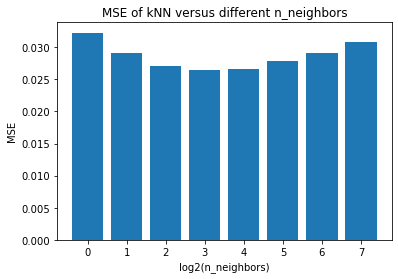

In [22]:
fig1 = plt.bar([0, 1, 2, 3, 4, 5, 6, 7],[mean_absolute_error(kNN_neighbor_1,test_data['bandgap']),mean_absolute_error(kNN_neighbor_2,test_data['bandgap']),mean_absolute_error(kNN_neighbor_4,test_data['bandgap']),mean_absolute_error(kNN_neighbor_8,test_data['bandgap']),mean_absolute_error(kNN_neighbor_16,test_data['bandgap']),mean_absolute_error(kNN_neighbor_32,test_data['bandgap']),mean_absolute_error(kNN_neighbor_64,test_data['bandgap']),mean_absolute_error(kNN_neighbor_128,test_data['bandgap'])])
plt.title('MSE of kNN versus different n_neighbors')
plt.xlabel('log2(n_neighbors)')
plt.ylabel('MSE')

Q1:Explain why the MAE improves when increasing from 1 and then worsens as you increase past 2^4.


A:This is the trade-off between overfitting and underfitting, when number of neighbor is not enough, the data will be overfitted while the number of neighbor is too much will lead to the underfitting. 


In [23]:
model = Pipeline([
    ('fingerprint', MorganFingerprintTransformer()),
    ('RFE', RFE(RandomForestRegressor(), n_features_to_select=32, step=4)),
    ('knn', KNeighborsRegressor(n_neighbors=1, metric='jaccard', n_jobs=-1))  # n_jobs = -1 lets the model run all available processors
])

In [24]:
kNN_neighbor_RFE_1 = model.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])

In [25]:
model.set_params(knn__n_neighbors=2)

Pipeline(steps=[('fingerprint', MorganFingerprintTransformer()),
                ('RFE',
                 RFE(estimator=RandomForestRegressor(), n_features_to_select=32,
                     step=4)),
                ('knn',
                 KNeighborsRegressor(metric='jaccard', n_jobs=-1,
                                     n_neighbors=2))])

In [26]:
kNN_neighbor_RFE_2 = model.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])

In [27]:
model.set_params(knn__n_neighbors=4)

Pipeline(steps=[('fingerprint', MorganFingerprintTransformer()),
                ('RFE',
                 RFE(estimator=RandomForestRegressor(), n_features_to_select=32,
                     step=4)),
                ('knn',
                 KNeighborsRegressor(metric='jaccard', n_jobs=-1,
                                     n_neighbors=4))])

In [28]:
kNN_neighbor_RFE_4 = model.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])

In [29]:
model.set_params(knn__n_neighbors=8)

Pipeline(steps=[('fingerprint', MorganFingerprintTransformer()),
                ('RFE',
                 RFE(estimator=RandomForestRegressor(), n_features_to_select=32,
                     step=4)),
                ('knn',
                 KNeighborsRegressor(metric='jaccard', n_jobs=-1,
                                     n_neighbors=8))])

In [30]:
kNN_neighbor_RFE_8 = model.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])

In [31]:
model.set_params(knn__n_neighbors=16)

Pipeline(steps=[('fingerprint', MorganFingerprintTransformer()),
                ('RFE',
                 RFE(estimator=RandomForestRegressor(), n_features_to_select=32,
                     step=4)),
                ('knn',
                 KNeighborsRegressor(metric='jaccard', n_jobs=-1,
                                     n_neighbors=16))])

In [32]:
kNN_neighbor_RFE_16 = model.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])

In [33]:
model.set_params(knn__n_neighbors=32)

Pipeline(steps=[('fingerprint', MorganFingerprintTransformer()),
                ('RFE',
                 RFE(estimator=RandomForestRegressor(), n_features_to_select=32,
                     step=4)),
                ('knn',
                 KNeighborsRegressor(metric='jaccard', n_jobs=-1,
                                     n_neighbors=32))])

In [34]:
kNN_neighbor_RFE_32 = model.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])

In [35]:
model.set_params(knn__n_neighbors=64)

Pipeline(steps=[('fingerprint', MorganFingerprintTransformer()),
                ('RFE',
                 RFE(estimator=RandomForestRegressor(), n_features_to_select=32,
                     step=4)),
                ('knn',
                 KNeighborsRegressor(metric='jaccard', n_jobs=-1,
                                     n_neighbors=64))])

In [36]:
kNN_neighbor_RFE_64 = model.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])

In [37]:
model.set_params(knn__n_neighbors=128)

Pipeline(steps=[('fingerprint', MorganFingerprintTransformer()),
                ('RFE',
                 RFE(estimator=RandomForestRegressor(), n_features_to_select=32,
                     step=4)),
                ('knn',
                 KNeighborsRegressor(metric='jaccard', n_jobs=-1,
                                     n_neighbors=128))])

In [38]:
kNN_neighbor_RFE_128 = model.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])

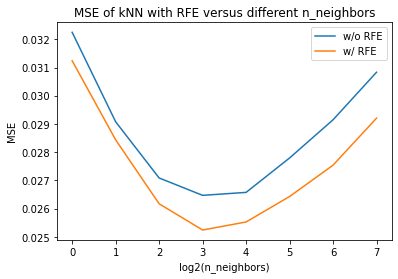

In [48]:
plt.plot([0, 1, 2, 3, 4, 5, 6, 7],[mean_absolute_error(kNN_neighbor_1,test_data['bandgap']),mean_absolute_error(kNN_neighbor_2,test_data['bandgap']),mean_absolute_error(kNN_neighbor_4,test_data['bandgap']),mean_absolute_error(kNN_neighbor_8,test_data['bandgap']),mean_absolute_error(kNN_neighbor_16,test_data['bandgap']),mean_absolute_error(kNN_neighbor_32,test_data['bandgap']),mean_absolute_error(kNN_neighbor_64,test_data['bandgap']),mean_absolute_error(kNN_neighbor_128,test_data['bandgap'])],
    [0, 1, 2, 3, 4, 5, 6, 7],[mean_absolute_error(kNN_neighbor_RFE_1,test_data['bandgap']),mean_absolute_error(kNN_neighbor_RFE_2,test_data['bandgap']),mean_absolute_error(kNN_neighbor_RFE_4,test_data['bandgap']),mean_absolute_error(kNN_neighbor_RFE_8,test_data['bandgap']),mean_absolute_error(kNN_neighbor_RFE_16,test_data['bandgap']),mean_absolute_error(kNN_neighbor_RFE_32,test_data['bandgap']),mean_absolute_error(kNN_neighbor_RFE_64,test_data['bandgap']),mean_absolute_error(kNN_neighbor_RFE_128,test_data['bandgap'])])
plt.title('MSE of kNN with RFE versus different n_neighbors')
plt.xlabel('log2(n_neighbors)')
plt.ylabel('MSE')
plt.legend(['w/o RFE','w/ RFE'])

Q2:Compare the MAE versus number of neighbors to kNN without feature selection.


It is clear that the MAE of kNN with feature selection is smaller than those without. 


Q3:Why would the model with the feature selection perform better? In general terms, explain the disadvantage of using a general-purpose distance metrics such as fingerprints and how must one must account for that.

With the feature selection before the fitting, we can train the model with those important features and this could decrease the noise from irrelevant features. 
